In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Data

In [2]:
from covid19be import load_data
data = load_data()

In [3]:
data.tail(25)

,n_hospitalized,n_hospitalized_in,n_hospitalized_out,n_icu,n_daily_deaths,date,n_deaths
49,5181,320,399,1150,254,2020-04-16,5716
50,5088,303,387,1119,202,2020-04-17,5918
51,4892,265,409,1081,211,2020-04-18,6129
52,4940,232,138,1071,215,2020-04-19,6344
53,4996,172,106,1079,199,2020-04-20,6543
54,4765,263,432,1020,202,2020-04-21,6745
55,4527,211,367,993,191,2020-04-22,6936
56,4355,210,322,970,173,2020-04-23,7109
57,4195,217,295,934,147,2020-04-24,7256
58,3957,202,368,901,155,2020-04-25,7411


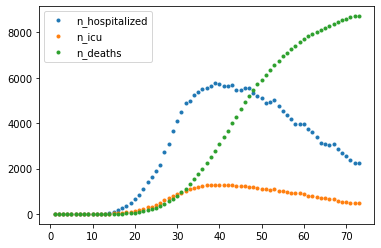

In [4]:
data[["n_hospitalized", "n_icu", "n_deaths"]].plot(style=".")

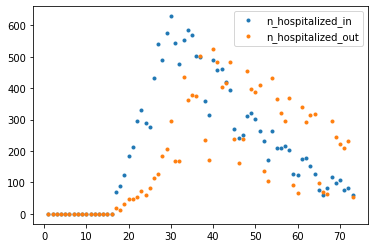

In [5]:
data[["n_hospitalized_in", "n_hospitalized_out"]].plot(style=".")

# SEIR model

<div class="alert alert-danger">
Disclaimer: All models are wrong, but some are useful.
</div>

Python re-implementation of Nicolas Vandewalle's SEIR model (see `seir-vdwnico.m`).

In [6]:
opts = {
    "frac_dh": 3594 / 7844,  # deaths in hospitals / total deaths
    "hh": 0.05,              # fraction of hospitalized 
    "gamma": 1 / 12.4,       # inverse recovery time"
    "epsilon": 1 / 5.2,      # inverse incubation time 
    "dea": 0.5,              # fatality rate in icu 
    "n0": 11000000,          # population size
    "n0_MRS": 400000,        # population en MR/MRS + personnel soignant
    "e0_factor": 37,         # e0 = i0 * factor
    "e0_MRS_factor": 20,     # e0_MRS = i0_MRS * factor
    "window": 7,             # size of the window for fitting Re's"
}

def smoothen(v, n_pts=opts["window"]):
    box = np.ones(n_pts) / n_pts
    return np.convolve(v, box, mode="same")

def SEIR(r0, i0=3, gg=0.75, n_futures=0, opts=opts):   
    # Load hyper-parameters
    hh = opts["hh"]
    gamma = opts["gamma"]
    epsilon = opts["epsilon"]
    dea = opts["dea"]
    n0 = opts["n0"]
    n0_MRS = opts["n0_MRS"]
    e0_factor = opts["e0_factor"]
    window = opts["window"]
    
    # Smoothen and extend R0s
    r0 = smoothen(r0)
    r0 = np.concatenate((r0, np.array([r0[-1]] * (window + n_futures))))
    
    # Initial conditions
    drea = dea * 1 / 5
    rrea = (1 - dea) * 1 / 20
    hospi = 0.0
    
    n = [n0-n0_MRS]
    i = [i0]
    e = [i[-1] * e0_factor]
    h = [0.0]
    l = [0.0]
    r = [0.0]
    m = [0.0]
    s = [n[-1] - e[-1] - i[-1] - r[-1]]
    
    # Simulate forward
    n_days = len(r0)
    
    for day in range(n_days):
        lam = gamma * r0[day]
        
        if day == 14:
            hospi = hh / 7
            
        ds = -lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1]
        de = lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1] - epsilon * e[-1]
        di = epsilon * e[-1] - gamma * i[-1] - hospi * i[-1]
        dh = hospi * i[-1] - gg * h[-1] / 7 - (1 - gg) * h[-1] / (4 + 2 * np.tanh((l[-1]-500)/300)) + rrea * l[-1]
        dl = (1 - gg) * h[-1] / (4 + 2 * np.tanh((l[-1]-500)/300)) - drea * l[-1] - rrea * l[-1]
        dr = gamma * i[-1] + gg * h[-1] / 7
        dm = drea * l[-1] 
        
        s.append(s[-1] + ds)
        e.append(e[-1] + de)
        i.append(i[-1] + di)
        h.append(h[-1] + dh)
        l.append(l[-1] + dl)
        if l[-1] > 1895:
            dm = dm + (l[-1] - 1895)
            l[-1] = 1895
        r.append(r[-1] + dr)
        m.append(m[-1] + dm)
        n.append(s[-1] + e[-1] + i[-1] + h[-1] + l[-1] + r[-1])
        
    return np.array(s), np.array(e), np.array(i), np.array(h), np.array(l), np.array(m), np.array(r)

def SEIR_MRS(r0_mrs, n_futures=0, opts=opts):
    # Load hyper-parameters
    gamma = opts["gamma"]
    epsilon = opts["epsilon"]
    n0_MRS = opts["n0_MRS"]
    e0_MRS_factor = opts["e0_MRS_factor"]
    window = opts["window"]
    
    # Smoothen and extend R0s
    r0_mrs = smoothen(r0_mrs)
    r0_mrs = np.concatenate((r0_mrs, np.array([r0_mrs[-1]] * (window + n_futures))))
    
    # Initial conditions
    alpha = 0.15 / 10
    lam = gamma * 4.3
    
    n = [n0_MRS]
    i = [1]
    e = [i[-1] * e0_MRS_factor]
    r = [0.0]
    s = [n[-1] - e[-1] - i[-1] - r[-1]]
    m = [0.0]
    
    # Simulate forward
    n_days = len(r0_mrs)
    
    for day in range(n_days):
        lam = gamma * r0_mrs[day]
        
        ds = -lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1]
        de = lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1] - epsilon * e[-1]
        di = epsilon * e[-1] - (gamma + alpha) * i[-1]
        dr = gamma * i[-1]
        dm = alpha * i[-1]
        
        s.append(s[-1] + ds)
        e.append(e[-1] + de)
        i.append(i[-1] + di)
        r.append(r[-1] + dr)
        m.append(m[-1] + dm)
        n.append(s[-1] + e[-1] + i[-1] + r[-1])
        
    return np.array(s), np.array(e), np.array(i), np.array(m), np.array(r)   

def simulate(theta, n_futures=0):   
    # Unpack parameters
    r0, r0_mrs, i0, gg = theta
    
    # Simulate
    s, e, i, h, l, m, r = SEIR(r0, i0=i0, gg=gg, n_futures=n_futures)
    _, _, _, m_mrs, _ = SEIR_MRS(r0_mrs, n_futures=n_futures)
    
    return s, e, i, h, l, m, m_mrs, r

# Parameter fit

The procedure is different from the original implementation. All parameters are fit jointly, instead of using a greedy procedure to fit parameters sequentially. Results are therefore slightly different.

In [7]:
from distributions import poisson_logpdf
from scipy.optimize import minimize


# Pack-unpack helpers for passing parameters around
def pack(r0, r0_rms, i0, gg):
    v = np.zeros(len(r0) + len(r0_rms) + 2)
    v[:len(r0)] = r0
    v[len(r0):len(r0)+len(r0_rms)] = r0_rms
    v[-2] = i0
    v[-1] = gg
    return v 

def unpack(v):
    return v[:(len(v)-2)//2], v[(len(v)-2)//2:len(v)-2], v[-2], v[-1]

# Fit
def fit(data, logpdf=poisson_logpdf, window=opts["window"], frac_dh=opts["frac_dh"]):
    def cost(x):
        # parameters
        r0, r0_mrs, i0, gg = unpack(x)

        # cost
        c = 0.0

        s, e, i, h, l, m, r = SEIR(r0, i0=i0, gg=gg)
        c -= logpdf(data["n_hospitalized"].values[9:], mu=h[10:]+l[10:])
        c -= logpdf(data["n_icu"].values[9:], mu=l[10:])
        c -= logpdf(frac_dh * data["n_deaths"].values[9:-2], mu=m[10:-2])

        # fit on deaths with SEIR_MRS
        s, e, i, m_mrs, r = SEIR_MRS(r0_mrs)
        c -= logpdf(data["n_deaths"].values[:-2], mu=m[1:-2] + m_mrs[1:-2])

        # ^ we omit the last two death data points, because not consolidated yet

        return c
 
    # x0
    r0 = [4.3] * (len(data) - window)
    r0_rms = [4.3] * (len(data) - window)
    i0 = 3.0
    gg = 0.75
    x0 = pack(r0, r0_rms, i0, gg)

    # bounds
    bounds = []
    for _ in range(len(r0)):
        bounds.append((0.25, 7.5))
    for _ in range(len(r0_rms)):
        bounds.append((0.25, 7.5))
    bounds.append((1, 500))
    bounds.append((0.65, 0.85))

    # fit
    res = minimize(cost, x0=x0, bounds=bounds, options={"maxfun": 25000})
    
    return unpack(res.x)

In [8]:
theta = fit(data, logpdf=poisson_logpdf)
r0, r0_mrs, i0, gg = theta
print("R0 =", r0)
print("R0 (MRS) =", r0_mrs)
print("I0 =", i0)
print("gg =", gg)

R0 = [2.57154045 3.15843354 3.74700582 4.3344816  4.27790963 4.23896726
 4.21373415 4.20071306 4.17657229 4.14189078 4.09617838 4.06919357
 4.07316874 4.11281667 4.18528515 4.2778661  4.36721582 4.42652751
 4.39002803 4.20029369 3.80596653 3.16674941 2.27533572 1.15721596
 0.31255184 0.28440702 0.32316421 2.52834561 0.25121767 0.25
 0.25       0.26690344 0.25       0.25       0.34422194 0.37947521
 0.67934148 0.820069   0.85659443 1.24490081 0.52456345 0.7350978
 0.81935315 0.85015098 0.83563146 0.81516612 0.77091137 0.69990902
 0.61164966 0.51466349 0.41301625 0.31204411 0.26545843 0.2685289
 0.28357026 0.29988813 0.29456306 0.25033065 0.25018788 0.25006105
 2.06619248 0.25       0.25       1.40003766 3.72126096 0.25      ]
R0 (MRS) = [2.89586749 3.56225718 4.23008397 4.90040272 4.84888739 4.81918413
 4.8094172  4.81749898 4.82168116 4.82092765 4.81420389 4.80070966
 4.77986309 4.75062107 4.71359883 4.66733454 4.61256675 4.54810664
 4.47348451 4.38958233 4.29384104 4.18579773 4.064246

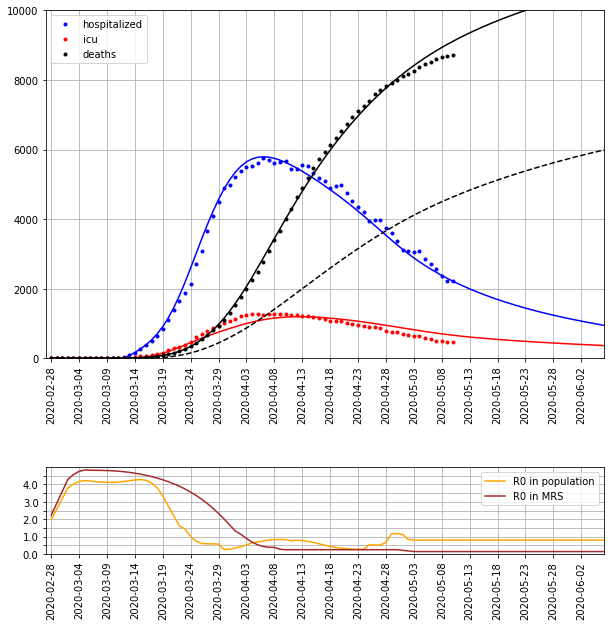

In [9]:
# Plots
n_futures = 365
s, e, i, h, l, m, m_mrs, r = simulate(theta, n_futures=n_futures)
n_days = len(data)

fig, ax = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={"height_ratios": (4,1)})

# Plot hospitalizations, icus and deaths
ax[0].plot(range(1, n_days+1 + n_futures), h[1:]+l[1:], c="b")
ax[0].plot(range(1, n_days+1), data["n_hospitalized"].values, ".", c="b", label="hospitalized")
ax[0].plot(range(1, n_days+1 + n_futures), l[1:], c="r")
ax[0].plot(range(1, n_days+1), data["n_icu"].values, ".", c="r", label="icu")
ax[0].plot(range(1, n_days+1 + n_futures), m[1:] + m_mrs[1:], c="k")
ax[0].plot(range(1, n_days+1 + n_futures), m[1:], "--", c="k")
ax[0].plot(range(1, n_days+1), data["n_deaths"].values, ".", c="k", label="deaths")
ax[0].grid()
ax[0].set_ylim(0, 10000)
ax[0].set_xlim(0, 100)
ax[0].set_xticks(np.arange(1, 100, 5))
ax[0].set_xticklabels([d.strftime('%Y-%m-%d') for d in pd.date_range(start="2020-02-28", end="2020-12-31")[:100:5]], rotation=90)
ax[0].legend()

# Plots R0s
window = opts["window"]
_r0 = smoothen(r0)
_r0_mrs = smoothen(r0_mrs)
_r0 = np.concatenate((_r0, np.array([_r0[-1]] * (window + n_futures))))
_r0_mrs = np.concatenate((_r0_mrs, np.array([_r0_mrs[-1]] * (window + n_futures))))

ax[1].plot(range(1, n_days+1 + n_futures), _r0, c="orange", label="R0 in population")
ax[1].plot(range(1, n_days+1 + n_futures), _r0_mrs, c="brown", label="R0 in MRS")
ax[1].grid(which="both")
ax[1].set_ylim(0, 5)
ax[1].set_yticks(np.arange(0, 5, step=0.5))

for j, label in enumerate(ax[1].get_yticklabels()):
    if j % 2 != 0:
        label.set_visible(False)
ax[1].set_xlim(0, 100)
ax[1].set_xticks(np.arange(1, 100, 5))
ax[1].set_xticklabels([d.strftime('%Y-%m-%d') for d in pd.date_range(start="2020-02-28", end="2020-12-31")[:100:5]], rotation=90)
ax[1].legend()

plt.subplots_adjust(hspace=0.5)

plt.show()